In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, lasso_path, Lasso
import matplotlib.pyplot as plt
from IPython.display import display

seed = 2023
np.random.seed(seed)


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.


In [2]:

df = pd.read_csv('Vehicle_Insurance.csv')
print("original shape of df: ", df.shape)
df.head(n=5)


original shape of df:  (8630, 11)


,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
0,2763.519279,Basic,F,56274,Married,69,0,1,Offer1,384.811147,Two-Door Car
1,6979.535903,Extended,F,0,Single,94,0,8,Offer3,1131.464935,Four-Door Car
2,12887.431650,Premium,F,48767,Married,108,0,2,Offer1,566.472247,Two-Door Car
3,7645.861827,Basic,M,0,Married,106,0,7,Offer1,529.881344,SUV
4,2813.692575,Basic,M,43836,Single,73,0,1,Offer1,138.130879,Four-Door Car


In [3]:
#removing rows with clv greater than 16000 and smaller than 2200
lower_bound = 2200
upper_bound = 16000

rows_to_drop = df.loc[(df['clv'] < lower_bound) | (df['clv'] > upper_bound)].index

df.drop(rows_to_drop, inplace=True)

print('The shape of the datafram now is: ', df.shape)
df.head(n=5)

The shape of the datafram now is:  (8212, 11)


,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
0,2763.519279,Basic,F,56274,Married,69,0,1,Offer1,384.811147,Two-Door Car
1,6979.535903,Extended,F,0,Single,94,0,8,Offer3,1131.464935,Four-Door Car
2,12887.431650,Premium,F,48767,Married,108,0,2,Offer1,566.472247,Two-Door Car
3,7645.861827,Basic,M,0,Married,106,0,7,Offer1,529.881344,SUV
4,2813.692575,Basic,M,43836,Single,73,0,1,Offer1,138.130879,Four-Door Car


In [4]:
#converting categorical features and removing collinear features during the encoding process 

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

ohe.fit(df[categorical_cols])

encoded_features = ohe.transform(df[categorical_cols])

encoded_feature_names = ohe.get_feature_names_out(categorical_cols)

df[encoded_feature_names] = encoded_features

# drop original categorical columns
df.drop(columns=categorical_cols, axis=1, inplace=True)

print("shape of df after encoding: ", df.shape)
df.head(n=3)


shape of df after encoding:  (8212, 19)


,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Coverage_Extended,Coverage_Premium,Gender_M,Marital.Status_Married,Marital.Status_Single,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car
0,2763.519279,56274,69,0,1,384.811147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6979.535903,0,94,0,8,1131.464935,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12887.431650,48767,108,0,2,566.472247,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
#applying sqrt transformation to the total.claim.amount column and log transformation to the target variable clv
df['Total.Claim.Amount'] = df['Total.Claim.Amount'].apply(np.sqrt)

df['clv'] = df['clv'].apply(np.log)

X = df.drop('clv', axis = 'columns').values
y = df['clv'].values

print("shape of X & Y : ", X.shape, y.shape)


shape of X & Y :  (8212, 18) (8212,)


In [6]:
#building new design matrix for features (excluding target), with polynomial expansion, degree = 2 include=bias = false (exlcuding 0)
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)

X_poly.shape

(8212, 189)

In [7]:
# standardizing design matrix with standard scaler
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)


X_poly_scaled_df = pd.DataFrame(X_poly_scaled)

X_poly_scaled_df.columns = poly_features.get_feature_names_out()

X_poly_scaled_df.shape

(8212, 189)

In [8]:
print('the resulting shape is: ', X_poly_scaled_df.shape)

the resulting shape is:  (8212, 189)


In [9]:
#splitting data into train and test sets (30% for test set)
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled_df, y, test_size=0.3, random_state=seed)

print(X_train.shape[0], y_train.shape[0])

avg_y = round(y.mean(), 2)
print("avg target variable 'clv': ", avg_y)

5748 5748
avg target variable 'clv':  8.62


In [10]:
#running ridge regression analysis of the target variable clv against all the tranformed predictor variables using training data 
from sklearn.linear_model import Ridge

m1 = Ridge(alpha=4.0, fit_intercept=True)
m1.fit(X_train, y_train)


print(f"Intercept: {m1.intercept_}")
print(f"First coefficient: {m1.coef_[0]}")
print(f"Second coefficient: {m1.coef_[1]}")
print(f"Third coefficient: {m1.coef_[2]}")

Intercept: 8.61973740056876
First coefficient: 0.030072902149530522
Second coefficient: 0.28254497396161443
Third coefficient: 0.026195175340134193


In [11]:
#varying the ridge coefficient alpha, using cross validation to select best alpha, reporting alpha that yields the smallest mse
lam = np.exp(np.linspace(-4,1,10))

mse_list = []

for alpha in lam:
    # create a Ridge regression object
    model_ridge = Ridge(alpha=alpha, fit_intercept=True)

    # perform cross-validation with 5 folds
    scores = cross_val_score(model_ridge, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

    # calculate the mean squared error for this alpha
    mse = np.mean(-scores)

    # append the MSE to the list
    mse_list.append(mse)


# find the alpha that yields the smallest MSE
best_alpha = lam[np.argmin(mse_list)]


print(f"Best alpha: {best_alpha}")
print(f"Minimum MSE: {min(mse_list)}")

Best alpha: 1.559623497606781
Minimum MSE: 0.11146764430105471


In [12]:
#re-fitting ridge regression with smallest alpha 
model_ridge = Ridge(alpha=best_alpha, fit_intercept=True)
model_ridge.fit(X_train, y_train)


print(f"Intercept: {model_ridge.intercept_}")
print(f"First coefficient: {model_ridge.coef_[0]}")
print(f"Second coefficient: {model_ridge.coef_[1]}")
print(f"Third coefficient: {model_ridge.coef_[2]}")

Intercept: 8.619696474629754
First coefficient: 0.028397620273842145
Second coefficient: 0.3308113294826027
Third coefficient: 0.02778566619245393


In [13]:
#fitting linear regression without penalty 
from sklearn.linear_model import LinearRegression

# create a LinearRegression object
model_linear = LinearRegression(fit_intercept=True)

# fit the model to the training data
model_linear.fit(X_train, y_train)

# print the first 3 parameters of the model
print(f"Intercept: {model_linear.intercept_}")
print(f"First coefficient: {model_linear.coef_[0]}")
print(f"Second coefficient: {model_linear.coef_[1]}")
print(f"Third coefficient: {model_linear.coef_[2]}")

Intercept: 8.619656731953228
First coefficient: 0.018364912333995467
Second coefficient: 0.23358725967540925
Third coefficient: 0.030344837166832984


In [14]:
## predicting on the test set
y_pred = model_linear.predict(X_test)
print(y_pred[:5])

[9.24153655 8.31222206 8.89943367 8.08133369 8.44777434]


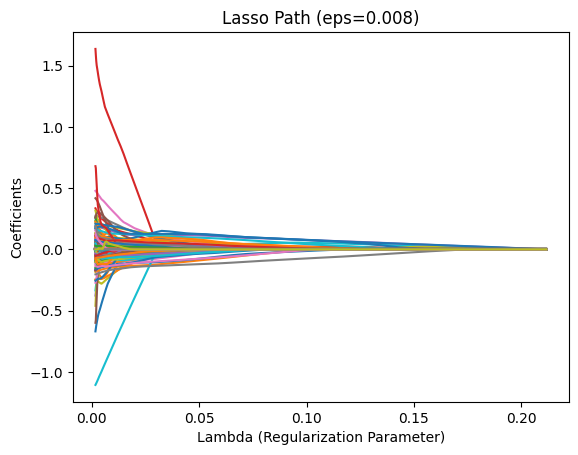

In [15]:
# fitting lasso regression to the training set, 

eps=8e-3
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, n_alphas = 50)

# Create the plot
plt.figure()

# Plot the Lasso path
plt.plot(alphas_lasso, coefs_lasso.T)

# Set the title and axis labels
plt.title(f"Lasso Path (eps={eps})")
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Coefficients")

# Show the plot
plt.show()


In [16]:
#automatically searching for the best tuning parameter using cv lasso of the lasso regression on the training set
from sklearn.linear_model import LassoCV

# Define the LassoCV model
model_lassocv = LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed)

# Fit the model to the training data
model_lassocv.fit(X_train, y_train)

# Get the best tuning parameter
best_alpha = model_lassocv.alpha_

# Get the number of non-zero coefficients
num_non_zero_coefs = np.count_nonzero(model_lassocv.coef_)

# Print the results
print("Best tuning parameter:", best_alpha)
print("Number of non-zero coefficients:", num_non_zero_coefs)

Best tuning parameter: 0.0019347932826026507
Number of non-zero coefficients: 92


In [17]:
#using cv elasticnet to automatically search for the best tuning parameters of the elasticnets regression on the training data set. 
from sklearn.linear_model import ElasticNetCV

# Define the ElasticNetCV model
model_elasticnetcv = ElasticNetCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, l1_ratio=[.7, .9, .95, .99,1])

# Fit the model to the training data
model_elasticnetcv.fit(X_train, y_train)

# Get the best tuning parameters
best_alpha = model_elasticnetcv.alpha_
best_l1_ratio = model_elasticnetcv.l1_ratio_

# Print the results
print("Best tuning parameters:")
print("alpha:", best_alpha)
print("l1_ratio:", best_l1_ratio)

Best tuning parameters:
alpha: 0.0019347932826026507
l1_ratio: 1.0



 the best tuning parameter alpha for both ElasticNet and Lasso regression is approximately 0.0019347932826026507. This value suggests that a moderate amount of regularization is applied, balancing between fitting the data and controlling for overfitting.

For ElasticNet regression, another important tuning parameter is l1_ratio, which determines the mix of L1 (Lasso) and L2 (Ridge) penalties. A l1_ratio of 1.0 means that only L1 penalty is applied, making the ElasticNet equivalent to Lasso regression
...

In [18]:
#conducting forward selection for the features of the regression model
selector = SequentialFeatureSelector(model_linear,
                                     n_features_to_select=20,  # Number of features to select
                                     direction='forward',      # Perform forward selection
                                     scoring='r2',             # Scoring metric
                                     cv=5)                     


selector.fit(X_train, y_train)


selected_feature_indices = np.where(selector.support_)[0]


print("Indices of selected features:", selected_feature_indices)

Indices of selected features: [  1   3  12  18  19  20  28  36  38  55  59  69  75 104 117 118 119 126
 131 143]


In [19]:
#re ftting linear regression based on the training set by using selected features
selected_features = selector.support_


selected_feature_names = [X_train.columns[i] for i in range(len(selected_features)) if selected_features[i]]


X_train_selected = X_train[selected_feature_names]

# Re-fit the linear regression model
model_linear.fit(X_train_selected, y_train)

# Print the first 3 parameters of the model
print(f"Intercept: {model_linear.intercept_}")
print(f"Coefficient for {selected_feature_names[0]}: {model_linear.coef_[0]}")
print(f"Coefficient for {selected_feature_names[1]}: {model_linear.coef_[1]}")
print(f"Coefficient for {selected_feature_names[2]}: {model_linear.coef_[2]}")

Intercept: 8.61894623157851
Coefficient for x1: 0.4818115681913016
Coefficient for x3: 1.071229529732939
Coefficient for x12: -0.01227780117627008


In [20]:
#predictions on model 3.3 (ridge regression with best alpha)
y_pred_ridge = model_ridge.predict(X_test)
#predictions on model 4.2 (lasso CV)
y_pred_lassocv = model_lassocv.predict(X_test)
#predictions on model 4.3 (Elastic net CV)
y_pred_elastic = model_elasticnetcv.predict(X_test)

#predictions on model 5.2 (linear of selected features)

selected_feature_names = [X_test.columns[i] for i in range(len(selected_features)) if selected_features[i]]
X_test_selected = X_test[selected_feature_names]
y_pred_linear = model_linear.predict(X_test_selected)


df_predictions = pd.DataFrame({
    "y_pred_linear": y_pred,
    "y_pred_linear_selected": y_pred_linear,
    "y_pred_ridge": y_pred_ridge,
    "y_pred_lasso": y_pred_lassocv,
    "y_pred_elasticnet": y_pred_elastic
})


df_predictions.head(n=5)

,y_pred_linear,y_pred_linear_selected,y_pred_ridge,y_pred_lasso,y_pred_elasticnet
0,9.241537,9.197035,9.244224,9.142903,9.142903
1,8.312222,8.300987,8.317220,8.303288,8.303288
2,8.899434,8.910826,8.894495,8.859596,8.859596
3,8.081334,8.025311,8.083858,8.085032,8.085032
4,8.447774,8.445480,8.433497,8.416404,8.416404


In [21]:
#using mse to assess the performance of the different models
from sklearn.metrics import mean_squared_error

# Calculate mean squared error for each model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lassocv = mean_squared_error(y_test, y_pred_lassocv)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
mse_linear = mean_squared_error(y_test, y_pred)
mse_linear_selected = mean_squared_error(y_test, y_pred_linear)

# Print the MSE for each model
print("Mean Squared Error for Linear Regression", mse_linear)
print("Mean Squared Error for Ridge Regression:", mse_ridge)
print("Mean Squared Error for Lasso CV:", mse_lassocv)
print("Mean Squared Error for Elastic Net CV:", mse_elastic)
print("Mean Squared Error for Linear Regression of Selected Features:", mse_linear_selected)

Mean Squared Error for Linear Regression 0.11048051028093514
Mean Squared Error for Ridge Regression: 0.1101501999617784
Mean Squared Error for Lasso CV: 0.10992600726531618
Mean Squared Error for Elastic Net CV: 0.10992600726531618
Mean Squared Error for Linear Regression of Selected Features: 0.11077019282893105



Elastic Net CV model and Lasso CV model both yield the smallest mean squared error on the test dataset with both having a value of: 0.10992600726531618
...